# PyKEEN Knowledge Graph Embedding

Jay Urbain, PhD

3/8/2024

This task will guide you through the process of using PyKEEN for knowledge graph embedding. 

1. Data prepration
2. Creating subject-predicate-object triples
3. Modeling
4. Evaluation

References:  
https://pykeen.github.io/  

https://github.com/pykeen/pykeen 

Complete Guide to PyKeen: Python KnowlEdge EmbeddiNgs for Knowledge Graphs    
https://analyticsindiamag.com/complete-guide-to-pykeen-python-knowledge-embeddings-for-knowledge-graphs/

Stanford CS224W: Machine Learning w/ Graphs I 2023 I Knowledge Graph Embeddings   
https://www.youtube.com/watch?v=isI_TUMoP60 


In [1]:
!pip install pykeen
!pip install seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Data Preparation

In [3]:
import pandas as pd

# Define the subjects, predicates, and objects
subjects =   ['Alice', 'Bob', 'Charlie', 'David', 'Eve', 'Alice', 'Bob', 'David', 'Eve', 'Frank', 'David']
predicates = ['like', 'like', 'like', 'like', 'like', 'has', 'has', 'has' , 'has','has', 'has']
objects =    ['movie', 'movie', 'movie', 'music', 'music', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat']

# Create a dataframe
df = pd.DataFrame({'subject': subjects, 'predicate': predicates, 'object': objects})

# Save the dataframe to a TSV file
df.to_csv('dataset10.csv', sep=',', index=False, header=False)
df.to_csv('dataset10.tsv', sep='\t', index=False, header=False)

df

,subject,predicate,object
0,Alice,like,movie
1,Bob,like,movie
2,Charlie,like,movie
3,David,like,music
4,Eve,like,music
5,Alice,has,cat
6,Bob,has,cat
7,David,has,dog
8,Eve,has,dog
9,Frank,has,dog


The triples represent entity relationships for populating the knowledge graph. In PyKEEN, we can use the `TriplesFactory` class to create these triples.

In [4]:
from pykeen.triples import TriplesFactory

# Assuming your dataframe has columns 'subject', 'predicate', 'object'
triples_factory = TriplesFactory.from_labeled_triples(
    triples=df[['subject', 'predicate', 'object']].values,
)

# Display the first few triples
triples_factory.triples

Reconstructing all label-based triples. This is expensive and rarely needed.


array([['Alice', 'has', 'cat'],
       ['Alice', 'like', 'movie'],
       ['Bob', 'has', 'cat'],
       ['Bob', 'like', 'movie'],
       ['Charlie', 'like', 'movie'],
       ['David', 'has', 'cat'],
       ['David', 'has', 'dog'],
       ['David', 'like', 'music'],
       ['Eve', 'has', 'dog'],
       ['Eve', 'like', 'music'],
       ['Frank', 'has', 'dog']], dtype='<U7')

Create training, validation, testing triples `triples_factory.split(ratios=(.6, .2, .2))`

In [5]:

training = triples_factory
validation = triples_factory
testing = triples_factory

d=training
id_to_entity={v: k for k, v in d.entity_to_id.items()}
id_to_relation={v: k for k, v in d.relation_to_id.items()}

for i in d.map_triples(d.triples):
    s,p,o =int(i[0]), int(i[1]), int(i[2])
    h,r,t = id_to_entity[s], id_to_relation[p], id_to_entity[o]
    print(f"{s:2d}:{h:7}{p:2d}:{r:7} {o:2d}:{t:7}")

Reconstructing all label-based triples. This is expensive and rarely needed.


 0:Alice   0:has      6:cat    
 0:Alice   1:like     8:movie  
 1:Bob     0:has      6:cat    
 1:Bob     1:like     8:movie  
 2:Charlie 1:like     8:movie  
 3:David   0:has      6:cat    
 3:David   0:has      7:dog    
 3:David   1:like     9:music  
 4:Eve     0:has      7:dog    
 4:Eve     1:like     9:music  
 5:Frank   0:has      7:dog    


## Setup Embedding Model

PyKEEN provides several models for this purpose. TransE is a goog place to start. Also try TransR.

No random seed is specified. Setting to 3509915222.


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Evaluating on cuda:0:   0%|          | 0.00/11.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='softplus Loss'>

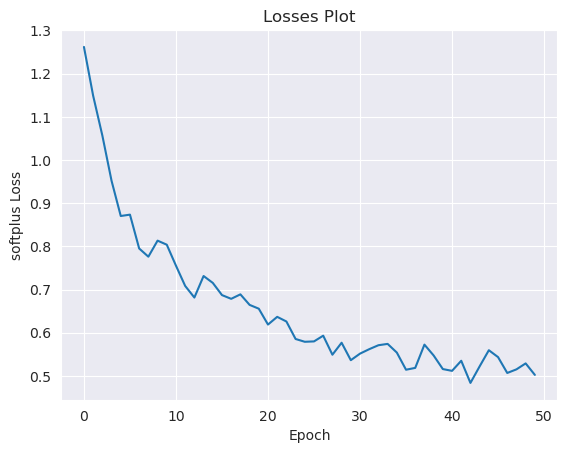

In [6]:
from pykeen.pipeline import pipeline

result = pipeline(
    model='TransE',
    loss="softplus",
    training=training,
    testing=testing,
    validation=validation,
    model_kwargs=dict(embedding_dim=3, random_seed=42),  # Increase the embedding dimension
    optimizer_kwargs=dict(lr=0.1),  # Adjust the learning rate
    training_kwargs=dict(num_epochs=50, use_tqdm_batch=False),  # Increase the number of epochs
)

# The trained model is stored in the pipeline result
model = result.model

#plot loss
result.plot_losses()

## Model Ealuation

PyKEEN provides several evaluation metrics, such as Hits@10, Mean Rank, and Mean Reciprocal Rank. 

These metrics can be calculated using the `Evaluator` class.

In [7]:
from pykeen.evaluation import RankBasedEvaluator
# The result object also contains the evaluation metrics result.metric_results.to_df()

# Create an evaluator
evaluator = RankBasedEvaluator()

# Evaluate the model
metrics = evaluator.evaluate(result.model, testing.mapped_triples, additional_filter_triples=[training.mapped_triples, validation.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

Evaluating on cuda:0:   0%|          | 0.00/11.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.05s seconds


Hits@1: 0.9090909090909091
Hits@3: 1.0
Hits@5: 1.0
Hits@10: 1.0
Mean Reciprocal Rank: 0.9545454382896423


## Embedding Visualization

We can use Principal Component Analysis (PCA) to reduce the dimensionality of our embeddings and then plot them.

(-1.0, 1.0)

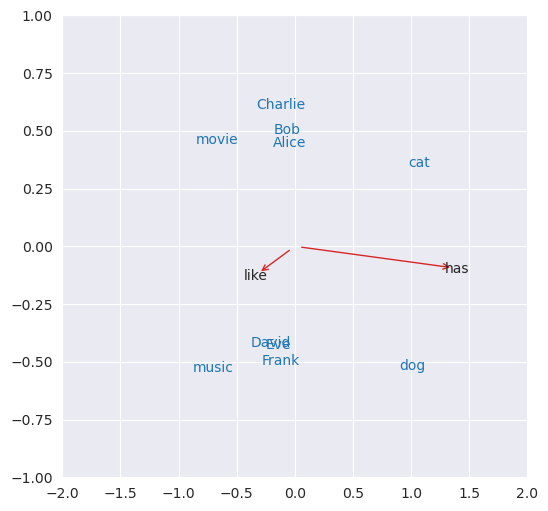

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.figure(figsize=(6, 6))
pca = PCA(n_components=2)
# entity_embeddings = model.entity_representations[0](indices=None).detach().numpy()
entity_embeddings = model.entity_representations[0](indices=None).cpu().detach().numpy()

m = pca.fit(entity_embeddings)

eu = m.transform(entity_embeddings)
# plt.plot(eu[:, 0], eu[:, 1],'.b')
for i, entity in enumerate(triples_factory.entity_id_to_label):
    plt.annotate(
        text=id_to_entity[entity],
        xy=(eu[i, 0], eu[i, 1]),
        color="tab:blue",
        ha="center", va="center"
    )

    
# relation_embeddings = model.relation_representations[0](indices=None).detach().numpy()
relation_embeddings = model.relation_representations[0](indices=None).cpu().detach().numpy()

ru = pca.transform(relation_embeddings)
for i, relation in enumerate(triples_factory.relation_id_to_label):
    plt.annotate(
        text=id_to_relation[relation],
        xy=(0,0), xytext=(ru[i, 0], ru[i, 1]),
        arrowprops=dict(
            arrowstyle="<-",
            color="tab:red",
            shrinkA=5,
            shrinkB=5,
            patchA=None,
            patchB=None,
            connectionstyle="arc3,rad=0."
        )
    )

plt.xlim([-2, 2])
plt.ylim([-1, 1])
